In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# validation modules
import experiment
import metrics

# requires cleanair
sys.path.append("../containers")
from cleanair.models import ModelData

In [2]:
# read experiment from file
name = 'basic'
cluster = 'laptop'
exp = experiment.experiment_from_dir(name, cluster)

In [ ]:
# load the data_model objects
secret_fp = "../terraform/.secrets/db_secrets.json"
model_data_list = []
for data_config in exp.data_config:
    model_data = ModelData(config=data_config, secretfile=secret_fp)
    model_data_list.append(model_data)

In [ ]:
# get a list of model data objects with updated prediction columns
updated_preds = []


for index, row in exp.experiment_df.iterrows():
    row = exp.experiment_df.loc[index]
    pid = row['param_id']
    model = row['model_name']
    did = row['data_id']
#     y_test = np.load(exp.data_config[did]['y_test_fp'])
    Y_pred = np.load(row['y_pred_fp'])
    
    # look at shapes
    data_config = exp.data_config[did]
    x_test = np.load(data_config['x_test_fp'])
    y_test = np.load(data_config['y_test_fp'])
    print("Xs :", x_test.shape)
    print("Ys :", y_test.shape)
    
    # update model_data
    normalised_df = model_data_list[did].normalised_pred_data_df.copy()
    predict_data_dict = model_data_list[did].get_pred_data_arrays(return_y=True).copy()
    
    # Create new dataframe with predictions
    predict_df = pd.DataFrame(index=predict_data_dict['index'])
    print("Pred index shape:", predict_df.shape)
    print("Y pred shape:", Y_pred[:, 0].shape)
    predict_df['predict_mean'] = Y_pred[:, 0]
    predict_df['predict_var'] = Y_pred[:, 1]
    predict_df['fit_start_time'] = exp.data_config[did]['pred_start_date']
    predict_df['tag'] = 0
    
    normalised_pred_data_df = pd.concat([model_data_list[did].normalised_pred_data_df, predict_df], axis=1, ignore_index=False)
    print(normalised_pred_data_df.sample(3))
    updated_preds.append(normalised_pred_data_df)
    

In [4]:
preds['measurement_start_utc'] = pd.to_datetime(preds['measurement_start_utc'])
gb = preds.groupby('point_id')
print(preds.columns)

Index(['Unnamed: 0', 'measurement_start_utc', 'point_id', 'source', 'location',
       'lat', 'lon', 'fit_start_time', 'predict_mean', 'predict_var', 'NO2'],
      dtype='object')


In [5]:
def plot_pretty_timeseries(time, series, ax, sigmas=None):
    ax.plot_date(time, series, ',', linestyle='-')
    ax.xaxis.grid(True, which="major")
    ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%m'))
    
    if not sigmas is None:
        factor = 2
        y_min = series - factor*np.sqrt(sigmas)
        y_max = series + factor*np.sqrt(sigmas)
        ax.fill_between(time, y_min, y_max, color='orange', alpha=0.5)
        
        
    return ax

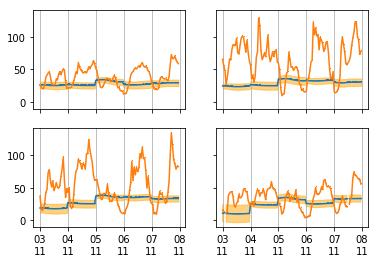

In [10]:
n = 2 # number of rows
c = 2 # number of columns
fig, axs = plt.subplots(n, c, sharex=True, sharey=True)
i = 0
j = 0
for point, row in gb:
    plot_pretty_timeseries(row['measurement_start_utc'], row['predict_mean'], axs[i, j], sigmas=row['predict_var'])
    plot_pretty_timeseries(row['measurement_start_utc'], row['NO2'], axs[i, j])
    i += j % c
    j += 1
    j = j % c
    if i == n:
        break